<a href="https://colab.research.google.com/github/VarshiniAG/Self-driving-cars-with-Deep-Reinforcement-Learning-/blob/main/SelfdrivingcarswithReinforcement_QLearning_using_OpenAI_Gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Reinforcement learning to implement Taxi-v2 game (simulating self drive cars)

The main purpose of this project is to illustrate how to apply RL approaches to construct an efficient and safe solution to solving the Taxi-v2 game in a simplified context. The Smart cab's job is to pick up and drop off passengers at different locations. Q-learning is implemented.

Library used: OpenAI’s Gym

In [ ]:
!pip install gymnasium

In [ ]:
import gymnasium as gym # openAi gym has been replaced by gymnasium
from gym import envs # Keep original for now as envs might still be valid or handled by gymnasium
import numpy as np
import datetime

# Keras-rl is incompatible with Python 3.12 because it requires Keras 2.x,
# and Keras 2.x relies on TensorFlow 2.x, which does not support Python 3.12.
# Therefore, the following lines attempting to downgrade Keras/TensorFlow
# and the subsequent imports for keras-rl will not work in this environment.
# The error "ModuleNotFoundError: No module named 'keras.utils.generic_utils'"
# is a direct result of this incompatibility.

# !pip uninstall -y keras tensorflow
# !pip install keras==2.10.0 tensorflow==2.10.0

# import keras # This import will now refer to Keras 2.x
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from time import sleep

# from rl.agents.dqn import DQNAgent
# from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
# from rl.memory import SequentialMemory
# from rl.core import Processor
# from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import gymnasium as gym

env = gym.make("Taxi-v3", render_mode="ansi")  # ansi required for ASCII text
state, info = env.reset()

print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [ ]:
env.observation_space.n

np.int64(500)

In [ ]:
env.action_space.n

np.int64(6)

In [ ]:
import gymnasium as gym

env = gym.make("Taxi-v3", render_mode="ansi")
env.reset()

env.unwrapped.s = 122  # Set Taxi to state 122

print(env.render())


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [ ]:
env.step(3)

(102,
 -1,
 False,
 False,
 {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

In [ ]:
import re

raw = env.render()
clean = re.sub(r'\x1b\[[0-9;]*m', '', raw)
print(clean)


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [ ]:
env.reset()
env.unwrapped.P[300]

{0: [(1.0, 400, -1, False)],
 1: [(1.0, 200, -1, False)],
 2: [(1.0, 300, -1, False)],
 3: [(1.0, 300, -1, False)],
 4: [(1.0, 300, -10, False)],
 5: [(1.0, 300, -10, False)]}

In [ ]:
env = gym.make('Taxi-v3')
random_policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
def random_policy_steps_count():
    state, info = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, truncated, info = env.step(env.action_space.sample())
        counter += 1
    return counter

Text(0.5, 1.0, 'Distribution of number of steps needed')

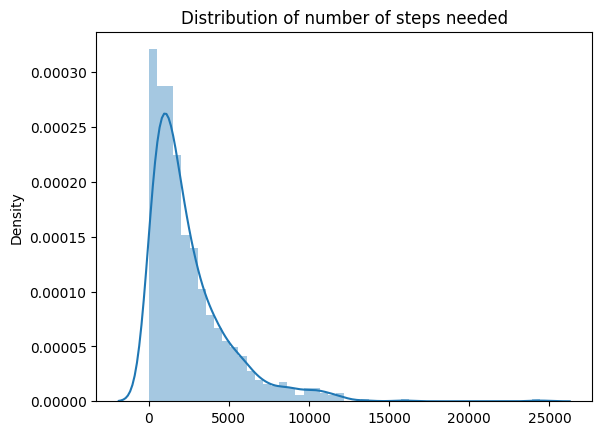

In [ ]:
counts = [random_policy_steps_count() for i in range(1000)]
sns.distplot(counts)
plt.title("Distribution of number of steps needed")

In [ ]:
print("An agent using Random search takes about an average of " + str(int(np.mean(counts)))
      + " steps to successfully complete its mission.")

An agent using Random search takes about an average of 2519 steps to successfully complete its mission.


In [ ]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.

    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.nS is a number of states in the environment.
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.

    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.observation_space.n)
    while True:
        # TODO: Implement!
        delta = 0  #delta = change in value of state from one iteration to next

        for state in range(env.observation_space.n):  #for all states
            val = 0  #initiate value as 0

            for action,act_prob in enumerate(policy[state]): #for all actions/action probabilities
                for prob,next_state,reward,done in env.unwrapped.P[state][action]:  #transition probabilities,state,rewards of each action
                    val += act_prob * prob * (reward + discount_factor * V[next_state])  #eqn to calculate
            delta = max(delta, np.abs(val-V[state]))
            V[state] = val
        if delta < theta:  #break if the change in value is less than the threshold (theta)
            break
    return np.array(V)

def policy_iteration(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.

    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.

    Returns:
        A tuple (policy, V).
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.

    """
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.

        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS

        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for prob, next_state, reward, done in env.unwrapped.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    # Start with a random policy
    policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n

    while True:
        # Implement this!
        curr_pol_val = policy_eval_fn(policy, env, discount_factor)  #eval current policy
        policy_stable = True  #Check if policy did improve (Set it as True first)
        for state in range(env.observation_space.n):  #for each states
            chosen_act = np.argmax(policy[state])  #best action (Highest prob) under current policy
            act_values = one_step_lookahead(state,curr_pol_val)  #use one step lookahead to find action values
            best_act = np.argmax(act_values) #find best action
            if chosen_act != best_act:
                policy_stable = False  #Greedily find best action
            policy[state] = np.eye(env.action_space.n)[best_act]  #update
        if policy_stable:
            return policy, curr_pol_val

    return policy, np.zeros(env.observation_space.n)

def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.

    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment.
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.

    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.

        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS

        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.action_space.n)
        for act in range(env.action_space.n):
            for prob, next_state, reward, done in env.unwrapped.P[state][act]:
                A[act] += prob * (reward + discount_factor*V[next_state])
        return A

    V = np.zeros(env.observation_space.n)
    while True:
        delta = 0  #checker for improvements across states
        for state in range(env.observation_space.n):
            act_values = one_step_lookahead(state,V)  #lookahead one step
            best_act_value = np.max(act_values) #get best action value
            delta = max(delta,np.abs(best_act_value - V[state]))  #find max delta across all states
            V[state] = best_act_value  #update value to best action value
        if delta < theta:  #if max improvement less than threshold
            break
    policy = np.zeros([env.observation_space.n, env.action_space.n])
    for state in range(env.observation_space.n):  #for all states, create deterministic policy
        act_val = one_step_lookahead(state,V)
        best_action = np.argmax(act_val)
        policy[state][best_action] = 1


    # Implement!
    return policy, V

In [ ]:
env = gym.make('Taxi-v3')
random_policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
policy_eval(random_policy,env,discount_factor=0.95)

array([-66.26438752, -71.80792647, -71.42078771, -71.82385699,
       -79.85874125, -79.76644406, -79.85914609, -79.85320521,
       -78.94845049, -78.98965515, -78.18067178, -78.9907127 ,
       -79.89007096, -79.88569714, -79.8903011 , -79.81473063,
       -58.97388718, -71.28332886, -70.42368566, -71.3187026 ,
       -71.76849805, -75.09061994, -74.85861632, -75.10016676,
       -79.84505188, -79.74379722, -79.84549601, -79.83897851,
       -79.0763058 , -79.11250001, -78.40188794, -79.11342896,
       -79.87942213, -79.87462379, -79.87967461, -79.79676993,
       -67.0351757 , -74.29222689, -73.47645597, -74.33919453,
       -79.64432128, -79.7878237 , -79.77780243, -79.78823608,
       -77.71728288, -76.22431024, -77.72383134, -77.6277274 ,
       -79.84088218, -79.84711324, -79.72477359, -79.84727316,
       -79.40240042, -79.37859483, -79.40365295, -78.99236538,
       -76.72709833, -73.48229756, -76.82709925, -76.20673132,
       -79.71298147, -79.82877523, -79.82068901, -79.82

In [ ]:
pol_iter_policy = policy_iteration(env,policy_eval,discount_factor=0.99)
pol_iter_policy[0]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [ ]:
val_iter_policy = value_iteration(env,discount_factor=0.99)
val_iter_policy[0]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [ ]:

for x in range(len(pol_iter_policy[0])):
    if not (pol_iter_policy[0][x] == val_iter_policy[0][x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

Same Policy


In [ ]:
def count(policy):
    curr_state, _ = env.reset() # Unpack the state and discard the info dictionary
    counter = 0
    reward = None
    while reward != 20:
        # env.step also returns 5 values in gymnasium: observation, reward, terminated, truncated, info
        curr_state, reward, terminated, truncated, info = env.step(np.argmax(policy[curr_state]))
        counter += 1
        if terminated or truncated: # Check for termination or truncation in gymnasium
            break # Exit if episode ends before reward 20
    return counter

An agent using a policy which has been improved using policy-iterated takes about an average of 13 steps to successfully complete its mission.


<Axes: ylabel='Density'>

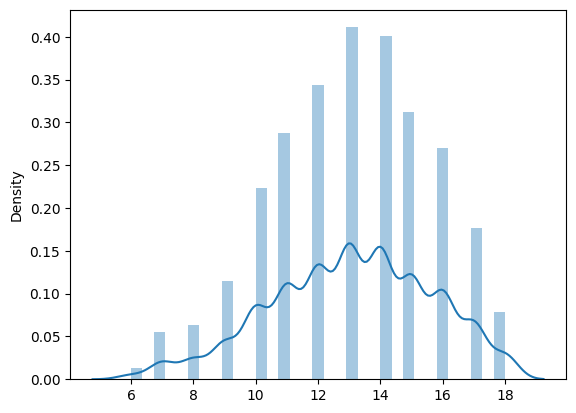

In [ ]:
pol_count = count(pol_iter_policy[0])
pol_counts = [count(pol_iter_policy[0]) for i in range(10000)]
print("An agent using a policy which has been improved using policy-iterated takes about an average of " + str(int(np.mean(pol_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(pol_counts)

An agent using a policy which has been value-iterated takes about an average of 13 steps to successfully complete its mission.


<Axes: ylabel='Density'>

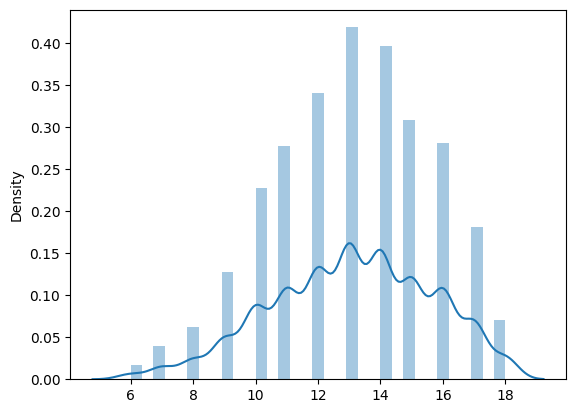

In [ ]:

val_count = count(val_iter_policy[0])
val_counts = [count(val_iter_policy[0]) for i in range(10000)]
print("An agent using a policy which has been value-iterated takes about an average of " + str(int(np.mean(val_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(val_counts)

In [ ]:
import random
from IPython.display import clear_output

def Q_learning_train(env,alpha,gamma,epsilon,episodes):
    """Q Learning Algorithm with epsilon greedy

    Args:
        env: Environment
        alpha: Learning Rate --> Extent to which our Q-values are being updated in every iteration.
        gamma: Discount Rate --> How much importance we want to give to future rewards
        epsilon: Probability of selecting random action instead of the 'optimal' action
        episodes: No. of episodes to train on

    Returns:
        Q-learning Trained policy

    """
    # Removed %%time from here as it's a magic command and cannot be inside a function definition
    """Training the agent"""

    # For plotting metrics
    all_epochs = []
    all_penalties = []

    #Initialize Q table of 500 x 6 size (500 states and 6 actions) with all zeroes
    q_table = np.zeros([env.observation_space.n, env.action_space.n])

    for i in range(1, episodes+1):
        state, _ = env.reset() # gymnasium returns (observation, info)

        epochs, penalties, reward = 0, 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space randomly
            else:
                action = np.argmax(q_table[state]) # Exploit learned values by choosing optimal values

            next_state, reward, terminated, truncated, info = env.step(action) # gymnasium returns 5 values

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1
            done = terminated or truncated # Update done based on gymnasium output

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")
    # Start with a random policy
    policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n # Use env.observation_space.n and env.action_space.n

    for state in range(env.observation_space.n):  #for each states
        best_act = np.argmax(q_table[state]) #find best action
        policy[state] = np.eye(env.action_space.n)[best_act]  #update

    print("Training finished.\n")
    return policy, q_table

In [ ]:
env = gym.make('Taxi-v3')
env.reset()
Q_learn_pol = Q_learning_train(env,0.2,0.95,0.1,100000)

Episode: 100000
Training finished.



An agent using a policy which has been improved using Q-learning takes about an average of 13 steps to successfully complete its mission.


<Axes: ylabel='Density'>

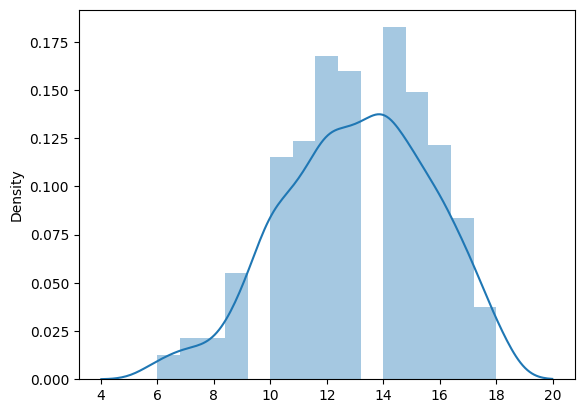

In [ ]:
Q_Learning_counts = count(Q_learn_pol[0])
Q_counts = [count(Q_learn_pol[0]) for i in range(1000)]
print("An agent using a policy which has been improved using Q-learning takes about an average of " + str(int(np.mean(Q_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(Q_counts)

In [ ]:
def view_policy(policy):
    curr_state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[0][curr_state]))
        curr_state = state
        counter += 1
        env.env.s = curr_state
        env.render()

In [ ]:
import gymnasium as gym
import numpy as np
import re

# Regex to remove ANSI color escape codes
ansi_escape = re.compile(r'\x1B\[[0-?]*[ -/]*[@-~]')

def view_policy(policy):
    env = gym.make("Taxi-v3", render_mode="ansi")

    # MUST reset once before using render() in Gymnasium
    env.reset()

    action_names = ["South", "North", "East", "West", "Pickup", "Dropoff"]

    # Your policy structure is: policy[0][state][action]
    pi = policy[0]

    for state in range(pi.shape[0]):
        # Set taxi to this state
        env.unwrapped.s = state

        # Render with ANSI codes
        raw = env.render()

        # Remove ANSI color codes for clean output
        clean = ansi_escape.sub('', raw)

        # Select best action (argmax Q-values)
        action = np.argmax(pi[state])

        # Print grid + action
        print(clean)
        print(f"  ({action_names[action]})")


In [ ]:
view_policy(pol_iter_policy)


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (South)
+---------+
|R: | : :G|
| : | : : |


In [ ]:
view_policy(val_iter_policy)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


  (South)
+---------+
|R: | : :G|
| : | : : |


In [ ]:
from IPython.display import clear_output
from matplotlib import animation
from IPython.display import display

def view_policy_anim(policy):
    # In gymnasium, env.reset() returns (observation, info)
    curr_state, _ = env.reset()

    penalties, reward = 0, 0
    frames = [] # for animation

    terminated = False
    truncated = False
    # The policy argument is a tuple (policy_matrix, value_function)
    policy_matrix = policy[0]

    while not terminated and not truncated and reward != 20:
        action = np.argmax(policy_matrix[curr_state])
        # In gymnasium, env.step returns observation, reward, terminated, truncated, info
        state, reward, terminated, truncated, info = env.step(action)
        curr_state = state
        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(), # render_mode is already set to 'ansi' for env
            'state': state,
            'action': action,
            'reward': reward
            }
        )

    # Only define print_frames if there are frames to print
    if frames:
        def print_frames(frames):
            for i, frame in enumerate(frames):
                clear_output(wait=True)
                print(frame['frame'])
                print(f"Timestep: {i + 1}")
                print(f"State: {frame['state']}")
                print(f"Action: {frame['action']}")
                print(f"Reward: {frame['reward']}")
                sleep(.7)
        print_frames(frames)
    else:
        print("No frames were generated, perhaps the episode terminated immediately or max steps reached.")

In [ ]:
import gymnasium as gym
import numpy as np
import re

ansi_escape = re.compile(r'\x1B\[[0-?]*[ -/]*[@-~]')

def view_policy(policy_matrix):
    # Define action_names as a list to ensure order consistency
    action_names = ["South", "North", "East", "West", "Pickup", "Dropoff"]
    env = gym.make("Taxi-v3", render_mode="ansi")
    env.reset() # Must call reset before render

    for s in range(len(policy_matrix)): # Assuming policy_matrix is [num_states, num_actions]
        env.unwrapped.s = s
        raw = env.render()              # contains ANSI color codes
        clean = ansi_escape.sub('', raw) # remove ANSI codes
        best_action_idx = np.argmax(policy_matrix[s]) # Get the index of the best action

        print(clean)
        print(f"  (Action for State {s}: {action_names[best_action_idx]})") # Index the list directly
        print("-" * 20) # Add a separator for better readability


In [ ]:
view_policy_anim(val_iter_policy)

None
Timestep: 17
State: 475
Action: 5
Reward: 20


In [ ]:
view_policy_anim(Q_learn_pol)

None
Timestep: 14
State: 85
Action: 5
Reward: 20


In [ ]:

view_policy_anim(pol_iter_policy)

None
Timestep: 13
State: 475
Action: 5
Reward: 20
